In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(data.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


# Exploratory Data Analysis

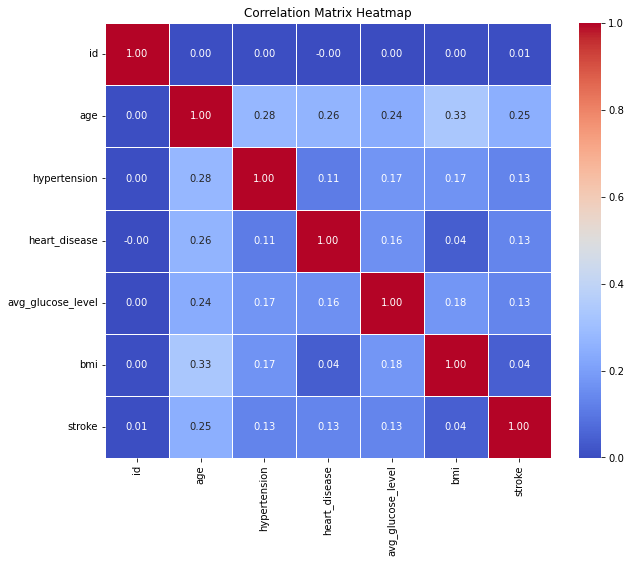

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


<AxesSubplot:>

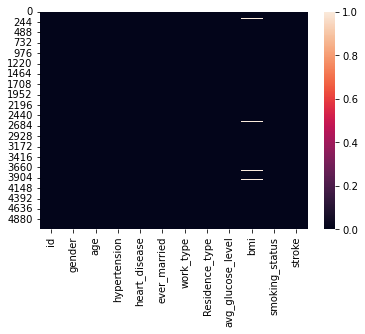

In [4]:
import seaborn as sns
sns.heatmap(data.isnull())

In [5]:
data.head()   # gives first 5 rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
data.shape   #size of dataset (rows, columns)

(5110, 12)

In [7]:
data.isna().sum()     #sum of all missing values in each column

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Data Preprocessing

In [9]:
def preprocessing_inputs(df):
    df=df.copy()
    
    #drop id col
    df=df.drop('id',axis=1)
    
    #Binary encoding
    df['ever_married']=df['ever_married'].replace({'No':0 , 'Yes':1 })
    df['Residence_type']=df['Residence_type'].replace({'Rural':0 , 'Urban':1 }) 
    
    #One-hot encoding for multi valued string cols
    for column in ['gender','work_type','smoking_status']:
        df=onehot_encode(df,column=column)
        
    #split into X and y
    y=df['stroke']
    X=df.drop('stroke',axis=1)
    
    #Train-test split 
    X_train,X_test,y_train,y_test = train_test_split(X , y , train_size=0.7, shuffle=True , random_state=1)
    
    #KNN imputation of missing values for training dataset only
    imputer=KNNImputer()
    imputer.fit(X_train)  #we do this only for x train because we have seen that y has no missing vlaues
    X_train = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    #Scale values so they are in the same range ( preffered by some algo)
    scaler= StandardScaler()
    scaler.fit(X_train)  
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train,X_test,y_train,y_test

In [10]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [11]:
X_train, X_test, y_train, y_test =preprocessing_inputs(data)   #The whole data is preprocessed before splitting


In [12]:
X_train.isna().sum()
#After running the preprocessing function we have no missing values. 

age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
gender_Female                     0
gender_Male                       0
gender_Other                      0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [13]:
y_train.value_counts()  #Number of values of 0 and 1. These are the values before we handles the class imbalance

0    3411
1     166
Name: stroke, dtype: int64

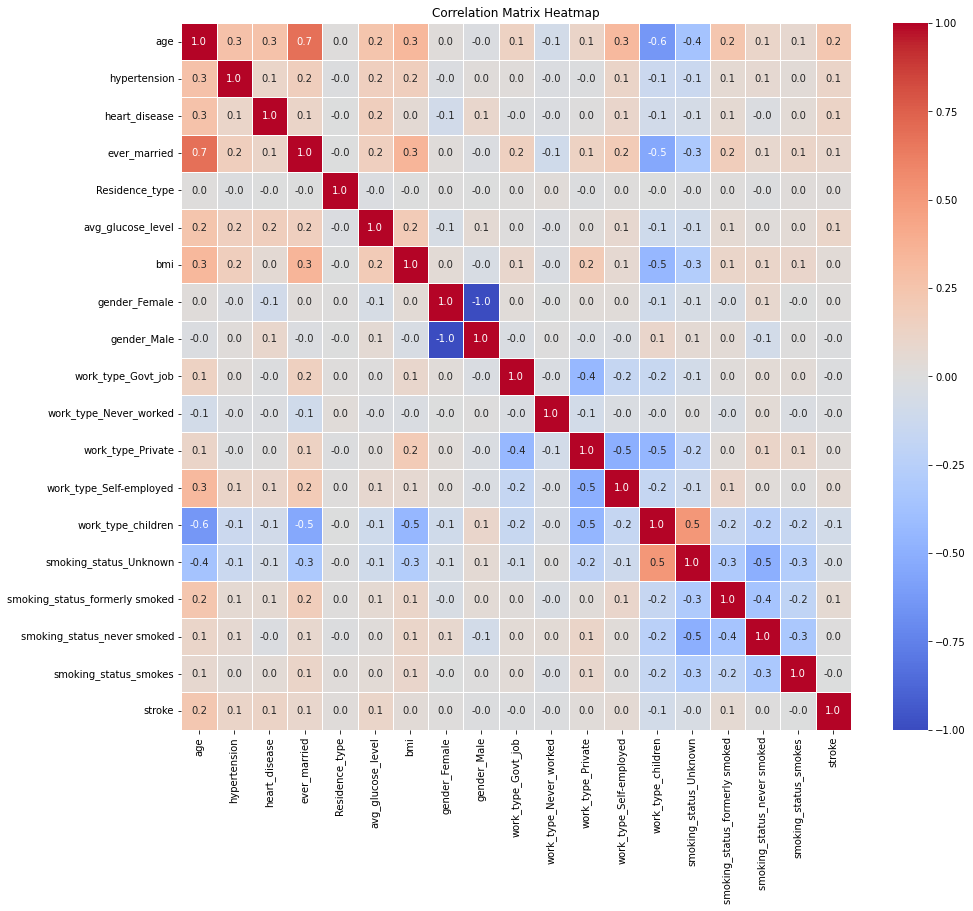

In [14]:
X_train_modified = X_train.drop('gender_Other', axis=1)
# Concatenate X_train and y_train
train_data = pd.concat([X_train_modified, y_train], axis=1)

# Compute the correlation matrix
corr_matrix = train_data.corr()

# Create a heatmap
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


# Handling Class Imbalance with oversampling

In [15]:
y_train.value_counts()[0] - y_train.value_counts()[1]   #Diff between number of values of 0 and 1

3245

In [16]:
oversampled_data = pd.concat([X_train, y_train], axis=1).copy()  #Just adding all the data into one for oversampling process


num_samples = y_train.value_counts()[0] - y_train.value_counts()[1]
new_samples = oversampled_data.query("stroke == 1").sample(num_samples, replace=True, random_state=1)

oversampled_data = pd.concat([oversampled_data, new_samples], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
#In the end we drop the old indexes so there are no duplicates or wrong info since our sampled data also contains duplicated values
#Thus we create or reset new indices for all rows

y_train_oversampled = oversampled_data['stroke']
X_train_oversampled = oversampled_data.drop('stroke', axis=1)

In [17]:
oversampled_data.query("stroke==1").sample(num_samples,replace=True) 
#get all the data which has stroke =1 then we use it to create required number of samples, we need to 
#make sure replace is true since we have only 166 values we need around 3500+ values which is a huge number
#so we keep replacing the values so we have more values that we can use to sample

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
2390,0.208585,-0.330374,-0.238161,-1.390817,0.994146,-0.472568,0.087925,-1.174021,1.174021,0.0,2.606344,-0.069103,-1.157341,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,1
4309,1.631725,-0.330374,4.198834,0.719002,-1.005888,0.004630,0.451231,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,1
4951,1.453832,-0.330374,-0.238161,0.719002,0.994146,0.015396,-0.516719,0.851774,-0.851774,0.0,-0.383679,-0.069103,-1.157341,2.282558,-0.392264,-0.659843,2.169088,-0.763376,-0.425344,1
1426,1.364886,-0.330374,-0.238161,0.719002,-1.005888,2.504866,0.606933,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,2.169088,-0.763376,-0.425344,1
5342,1.631725,-0.330374,4.198834,0.719002,-1.005888,-0.856611,-0.950091,0.851774,-0.851774,0.0,-0.383679,-0.069103,-1.157341,2.282558,-0.392264,-0.659843,2.169088,-0.763376,-0.425344,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,1.631725,3.026868,-0.238161,-1.390817,0.994146,-0.871771,0.827512,0.851774,-0.851774,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,1
5216,0.119639,-0.330374,-0.238161,0.719002,0.994146,-0.604830,0.230653,0.851774,-0.851774,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,1
6558,0.742262,-0.330374,4.198834,0.719002,0.994146,-0.302956,0.892388,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,-0.763376,2.351036,1
2789,1.587252,3.026868,-0.238161,0.719002,-1.005888,-0.674256,-0.591976,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,1


In [18]:
oversampled_data #since we have alot of duplicate data we need to  delete duplicates

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0.030692,-0.330374,-0.238161,0.719002,-1.005888,0.604862,2.073132,0.851774,-0.851774,0.0,2.606344,-0.069103,-1.157341,-0.438105,-0.392264,-0.659843,-0.461023,-0.763376,2.351036,0
1,-1.481394,-0.330374,-0.238161,-1.390817,0.994146,-0.769169,-0.470009,-1.174021,1.174021,0.0,-0.383679,-0.069103,-1.157341,-0.438105,2.549304,1.515511,-0.461023,-0.763376,-0.425344,0
2,-0.236146,-0.330374,-0.238161,0.719002,-1.005888,-0.536721,0.542057,0.851774,-0.851774,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,-0.763376,2.351036,0
3,-1.703759,-0.330374,-0.238161,-1.390817,-1.005888,-0.177285,-1.559926,-1.174021,1.174021,0.0,-0.383679,-0.069103,-1.157341,-0.438105,2.549304,1.515511,-0.461023,-0.763376,-0.425344,0
4,1.098047,-0.330374,4.198834,0.719002,0.994146,2.595164,0.373380,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,2.169088,-0.763376,-0.425344,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6817,1.142520,3.026868,-0.238161,-1.390817,0.994146,-0.653824,-0.054802,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,1.309970,-0.425344,0
6818,-0.058254,-0.330374,-0.238161,0.719002,-1.005888,-0.489924,-0.470009,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,1.515511,-0.461023,-0.763376,-0.425344,1
6819,0.742262,-0.330374,4.198834,0.719002,0.994146,-0.302956,0.892388,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,-0.763376,2.351036,1
6820,-0.547458,-0.330374,-0.238161,0.719002,0.994146,0.063950,0.526487,-1.174021,1.174021,0.0,-0.383679,-0.069103,0.864050,-0.438105,-0.392264,-0.659843,-0.461023,-0.763376,2.351036,0


In [19]:

oversampled_data['stroke'].value_counts() #now we have balanced the classes

0    3411
1    3411
Name: stroke, dtype: int64

# Training

In [20]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "                         Random Forest": RandomForestClassifier(),
}

for name, model in models.items():   #training our data in these models
    model.fit(X_train_oversampled, y_train_oversampled)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
                         Random Forest trained.


In [21]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
print("Model Performance\n-----------------")
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(
        "\n" + name + " Accuracy: {:.3f}%\n\t\t\t\t       Precision: {:.3f}\n\t\t\t\t     \tRecall: {:.3f}\n\t\t\t\t   \tMeanSquaredError: {:.3f}"\
        .format(accuracy_score(y_test, y_pred) * 100, metrics.precision_score(y_test, y_pred), metrics.recall_score(y_test, y_pred), mean_squared_error(y_test,y_pred))
    )
    

Model Performance
-----------------

                   Logistic Regression Accuracy: 73.190%
				       Precision: 0.151
				     	Recall: 0.855
				   	MeanSquaredError: 0.268

                   K-Nearest Neighbors Accuracy: 85.845%
				       Precision: 0.086
				     	Recall: 0.169
				   	MeanSquaredError: 0.142

                         Decision Tree Accuracy: 92.433%
				       Precision: 0.176
				     	Recall: 0.108
				   	MeanSquaredError: 0.076

                         Random Forest Accuracy: 93.803%
				       Precision: 0.071
				     	Recall: 0.012
				   	MeanSquaredError: 0.062


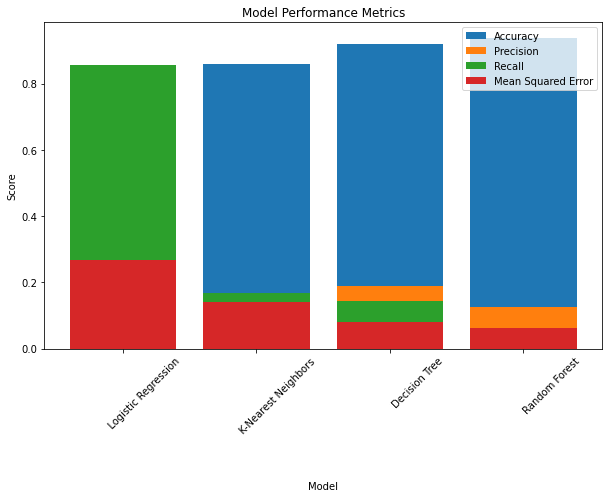

In [22]:
import matplotlib.pyplot as plt

accuracy_scores = []
precision_scores = []
recall_scores = []
mse_scores = []

for name, model in models.items():
    model.fit(X_train_oversampled, y_train_oversampled)
    y_pred = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracy_scores, label='Accuracy')
plt.bar(models.keys(), precision_scores, label='Precision')
plt.bar(models.keys(), recall_scores, label='Recall')
plt.bar(models.keys(), mse_scores, label='Mean Squared Error')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()
plt.xticks(rotation=45)
plt.show()
